

<center><table>
<tr>

<th> <img src= "INL1.png",align="middle",style="width: 10000px;"/> </th>
</tr>
<tr>
<th> <img src="PennNucDataCenter.jpeg"  ,align="middle", style="width: 500px;"/> </th>
</tr>
<center><table>

# <center>Nuclear-Powered Data Centers Economic Optimization Strategy</center>

#### Expected Outcome
- A journal paper evaluating <u>the economic threshold points</u> identifying the conditions under which user requirements would be better suited by a large, small, or micro-reactor. The use case will be focused on data centers and will provide INL with the credential to stake a claim as a leader in nuclear for data center research.

- With a framework on hand, the lab could then leverage its expertise to offer advisory support for the various data centers considering nuclear energy. Further, with interest growing in this area, it is possible that DOE-NE would sponsor research on coupling nuclear reactors with data centers. INL would be well positioned to lead such R&D activities.

#### Activity
- A framework is proposed to evaluate the **economic tradeoff** between large, small, and micro-reactors. 
- The intent is to map out ‘threshold values’ under a given set of requirements 
  - energy demand size
  - reliability 
  
- The framework would parametrize a set of important economic variables to quantifiably differentiate the different reactor classes. 
  - nuclear capacity
  - diseconomies of scale, 
   - economies of mass production, 
   - speed of deployment, 
   - downtime intervals  



### Required Imports

In [1]:
#!/usr/local/bin/python3

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
# import scipy as sp
# from scipy.optimize import curve_fit
from src import *



In [ ]:
# # Fuel lifetime estimation at each power 
# power_range = [1, 1000]
# fuelCycle_range = [30*12*2, 30*12*5]
# fuelCycle_interp = sp.interpolate.interp1d( power_range,  fuelCycle_range )

# ppp = 5 # MWe
# fuelCycle_estimated = int((fuelCycle_interp(ppp ))/30)

## The schedule for one reactor

In [ ]:
fig = plt.figure(figsize=(10, 3))
power = 10 # MWe
fuel_lifetime = 2*365 # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 6*365 # in days
inital_delay = 0

t_list = []
P_list = []
for time in range(levelization_period+1):
    P = calculate_duty_cycle( inital_delay, fuel_lifetime, refueling_period, levelization_period, power, time)
    t_list.append(time)
    P_list.append(P)



plt.plot((np.array(t_list))/365, P_list)
plt.xlim(0, levelization_period/365)
plt.ylim(0, 1.05*power)
plt.xlabel('Time (years)', fontsize=16) 
plt.ylabel('Power', fontsize=16) 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


plt.title(f"Refueling Schedule for one reactor \n Fuel Lifetime = {int(np.round(fuel_lifetime/365, 1))} years ,\
Refueling Duration = {refueling_period} days  \n",  fontsize=16)

plt.savefig(f'schedule.png', bbox_inches='tight')

plt.show()

## The schedule for 2 reactors
The second reactor should start after the first reactor with a delay equals 1 refueling period. This way we guarantee that:
1. Both reactors will never be off at the same time, 
2- Use the full power of the two reactors ASAP


In [ ]:
fig = plt.figure(figsize=(10, 3))
power =310 # MWe
fuel_lifetime = 2*365 # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 6*365 # in days
inital_delay1 = 0
inital_delay2 = refueling_period 

t_list = []
P_list1 = []
P_list2 = []
for time in range(levelization_period+1):
    P1 = calculate_duty_cycle( inital_delay1, fuel_lifetime, refueling_period, levelization_period, power, time)
    t_list.append(time)
    P_list1.append(P1)
    P2 = calculate_duty_cycle( inital_delay2, fuel_lifetime, refueling_period, levelization_period, 1.1*power, time) # I change the power her for visualization
    if P2 == 0:
        if P1 ==0:
            print("WARNING: P2 = 0 and P1 =0")
    P_list2.append(P2)

plt.plot( np.array(t_list)/365, P_list1, label = "reactor #1")
plt.plot(np.array(t_list)/365, P_list2, label = "reactor #2")
plt.legend( loc='lower right' , fontsize=16)
plt.xlim(0, levelization_period/365)

plt.xlabel('Time (years)', fontsize=16) 
plt.ylabel('Power', fontsize=16) 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.title(f"Refueling Schedule for two reactors \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years\
, Refueling Period = {refueling_period} days  \n", fontsize=16)

plt.savefig(f'schedule_2.png', bbox_inches='tight')

plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  \le \frac{fuel \, Lifetime}{Refueling \, Period} $

An example for visualization (not realistic):
- fuel lifetime = 4 months
- refueling period = 1 months
- number of reactors = 4

In [ ]:
fig = plt.figure(figsize=(10, 3))
power = 100 # MWe
fuel_lifetime = 2*365 # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 6*365 # in days
num_reactors = 4

initial_delay_list =list(refueling_period*np.linspace(0,  num_reactors-1, num_reactors) )
P_list_tot = []
for i in range(len(initial_delay_list)):
    
    delay = initial_delay_list[i] 
    power = power *(1+ i *0.05) # just for visualization
    
    t_list = []
    P_list = []

    for time in range(levelization_period+1):
       
        P = calculate_duty_cycle( int( delay), fuel_lifetime, refueling_period, levelization_period, power, time)
      
        t_list.append(time)
        P_list.append(P)

    P_list_tot.append(P_list)

    plt.plot(np.array(t_list)/365, P_list, label = f"reactor # {i+1}")
    plt.legend( loc='lower right' , fontsize=15)
    plt.xlim(0, levelization_period/365)

    plt.xlabel('Time (years)', fontsize= 16) 
    plt.ylabel('Power', fontsize=16) 

    plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years ,\
    Refueling Period = {refueling_period} days  \n", fontsize=16)
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f'schedule_4.png', bbox_inches='tight')

plt.show()

print( "startup period  = ", initial_delay_list[-1], "days")

In [ ]:
fig = plt.figure(figsize=(12, 6))

P_list_tot_array = (np.vstack(P_list_tot))
reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))

plt.plot(t_list,  reactors_down_list) 
plt.xlabel('Time (days)')
plt.ylabel('how many reactors are down at any day?')
plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  > \frac{fuel \, Lifetime}{Refueling \, Period} $

An example for visualization (not realistic):
- fuel lifetime = 4 months
- refueling period = 1 months
- number of reactors = 7

Since the total number of refueling  = 1 months * 7 reactors = 7 months which is longer than the fuel lifetime which is 4 months, this means that more than one reactor has to be down at sometime

Using increments of 1 months (the refueling period), all the reactors have to be refueled within one cycle.
The number of reactos to be refueled at the same time $= \frac{7}{4}  = 1\frac{3}{4} $

-Therefore, 2 reactors will be refueled each month (in the first 3 months) and 1 reactor is refueled in the 4th month

<br>


This can be formulated as follows
- $number \, of\, reactors \, down \, at \, one\,  refueling\, period \in  [ Ceiling[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}] \, , \, Floor[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}]] $

    - The number of refueling period where the ceiling value is taken is :  $ \frac {modulus(num \, of \, reactors \, \times \, refueling \, period \, , \, refueling \, period) }{refueling \, period}$

In [ ]:
fig = plt.figure(figsize=(18, 6))


power = 10 # MWe
fuel_lifetime = int(120) # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 30*12 # in days

num_reactors = 7
num_reactors_down_max = int(np.ceil(num_reactors * refueling_period/fuel_lifetime))
num_reactors_down_min = int(np.floor(num_reactors * refueling_period/fuel_lifetime))

# how many times the celing value is used
num_reactors_down_max_freq = int(np.ceil((num_reactors * refueling_period )% fuel_lifetime)/refueling_period) 
num_reactors_down_min_freq = int(fuel_lifetime /refueling_period)- num_reactors_down_max_freq

reactor_down_list1 = [num_reactors_down_max ]*num_reactors_down_max_freq
reactor_down_list2 = [num_reactors_down_min ]*num_reactors_down_min_freq
reactor_down_list = reactor_down_list1  + reactor_down_list2

assert len(reactor_down_list  ) == int(fuel_lifetime/refueling_period ) , "There is an assertion error. review!"

initial_delay_list = []
for n in np.linspace(0,  int(fuel_lifetime/refueling_period )-1, int(fuel_lifetime/refueling_period )):

    delay_list = [n*refueling_period] * reactor_down_list [int(n)]
    initial_delay_list.append(delay_list )
initial_delay_list = list(np.hstack(initial_delay_list))


P_list_tot = []
for i in range(len(initial_delay_list)):
    
    delay = initial_delay_list[i] 
    power = power *(1+ i *0.05) # just for visualization
    
    t_list = []
    P_list = []

    for time in range(levelization_period+1):
       
        P = calculate_duty_cycle( int( delay), fuel_lifetime, refueling_period, levelization_period, power, time)
      
        t_list.append(time)
        P_list.append(P)

    P_list_tot.append(P_list)

    plt.plot(t_list, P_list, label = f"reactor # {i+1}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlim(0, levelization_period)
    plt.xlabel('Time (days)')
    plt.ylabel('Power(MWe)')

    plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime, 1)} days , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.show()

print( "startup period  = ", initial_delay_list[-1], "days")

In [ ]:
fig = plt.figure(figsize=(12, 6))

P_list_tot_array = (np.vstack(P_list_tot))
reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))

plt.plot(t_list,  reactors_down_list) 
plt.xlabel('Time (days)')
plt.ylabel('how many reactors are down at any day?')
plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")




# General Example (should work for any variables)

ramp up to full power period  =  90.0 days


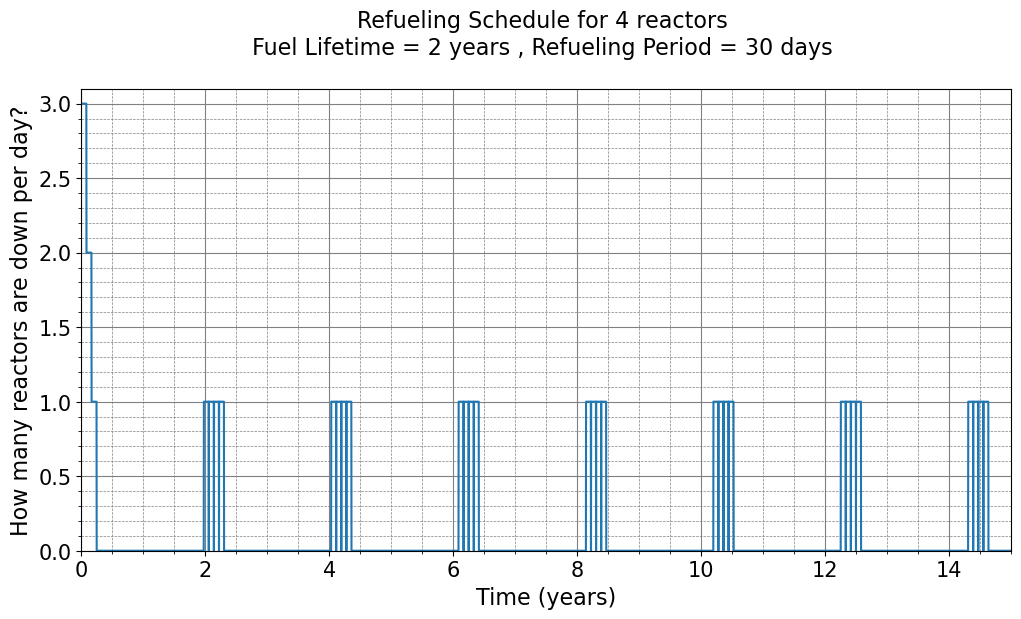

In [42]:
fig = plt.figure(figsize=(12, 6))

fuel_lifetime = 30 *24 # days
refueling_period = 30 # days
num_reactors = 4
power1 = 1
levelization_period = 15*365
schedule = calculate_schedule_multiple_reactors(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period) 
times =  schedule[0]
powers =  schedule[1]

# for n in range(len(powers)): # i can plot this but it is hard to see!
#     plt.plot(times, powers[n] )


P_list_tot_array = (np.vstack(powers))

reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))


plt.plot(np.array(times)/365,  reactors_down_list) 
plt.xlabel('Time (years)', fontsize=16)
plt.ylabel('How many reactors are down per day?', fontsize=16)
plt.title(f"Refueling Schedule for {num_reactors} reactors \n Fuel Lifetime = { int(np.round(fuel_lifetime/365, 1))} years , Refueling Period = {refueling_period} days  \n", fontsize=16)


plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.xlim(0, levelization_period/365)
plt.ylim(0, 3.1)
print( "ramp up to full power period  = ", schedule[2], "days")

# plt.savefig(f'Num_reactors_Down_4.png', bbox_inches='tight')





In [ ]:
fig = plt.figure(figsize=(12, 6))
num_reactors = 1000
schedule = calculate_schedule_multiple_reactors(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period) 
times =  schedule[0]
powers =  schedule[1]

# for n in range(len(powers)): # i can plot this but it is hard to see!
#     plt.plot(times, powers[n] )


P_list_tot_array = (np.vstack(powers))

reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))


plt.plot(np.array(times)/365,  reactors_down_list) 
plt.xlabel('Time (years)', fontsize=16)
plt.ylabel('How many reactors are down per day?', fontsize=16)
plt.title(f"Refueling Schedule for {num_reactors} reactors \n Fuel Lifetime = { int(np.round(fuel_lifetime/365, 1))} years , Refueling Period = {refueling_period} days  \n", fontsize=16)
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.minorticks_on()
plt.xlim(0, levelization_period/365)
plt.ylim(0, 1000)
print( "ramp up to full power period  = ", schedule[2], "days")

plt.savefig(f'Num_reactors_Down_1000.png', bbox_inches='tight')

# Capacity factor (An example: 1 MW microreactor, 1000 reactors)

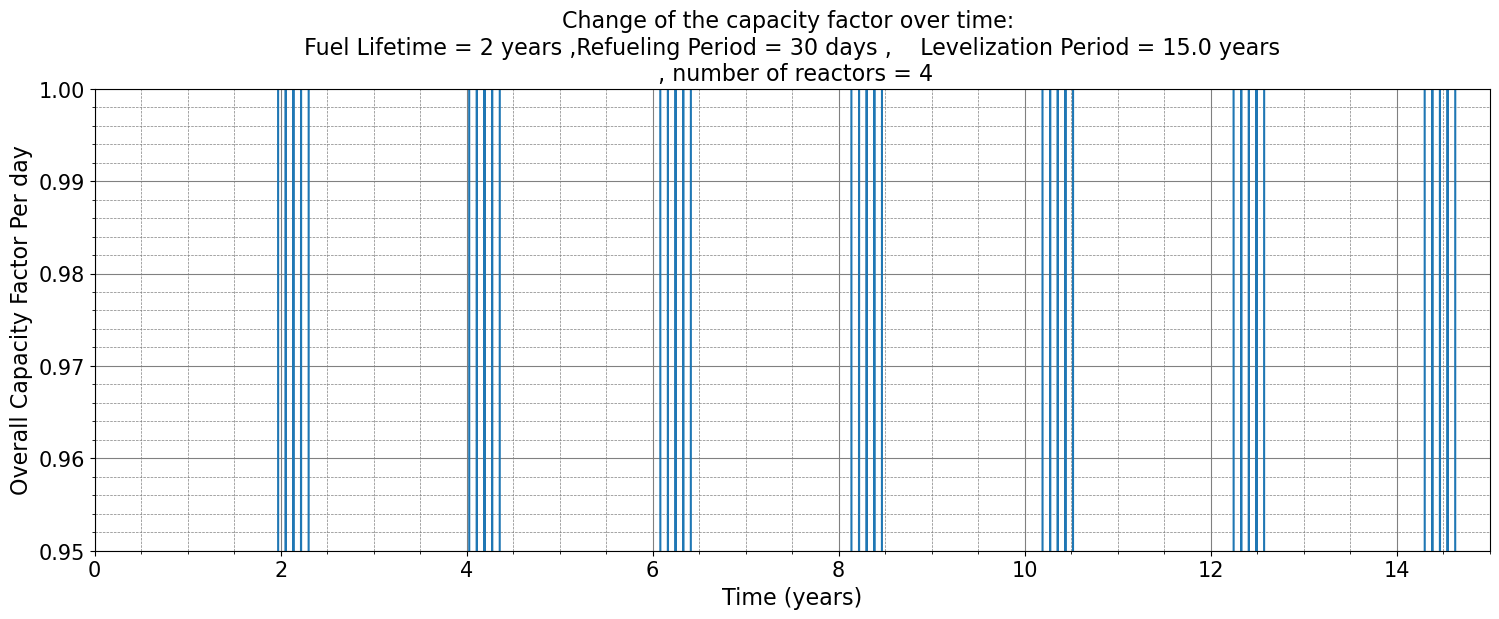

Capacity Factor over the plant lifetime is : 0.9623096917935388


In [43]:
fig = plt.figure(figsize=(18, 6))

# # remove the data before getting to the full power
times_array =np.reshape(np.array(times) , (1, len(times)))
times_power_array = np.concatenate((times_array , P_list_tot_array)) # merging the time and power in one array
times_power_array_excludingRampUp = times_power_array[:,int(schedule[2]):] # remove the initial rampup period

#extract time and power after excluding the initial ramp up period
times_array_excludingRampUp = times_power_array_excludingRampUp[0]
power_array_excludingRampUp = np.delete(times_power_array_excludingRampUp, (0), axis=0)


# nominal power and actual power
tot_nom_output_t    = power1*num_reactors # total nominal power (assuming 100% availability) at each timestep (at each day)
tot_actual_output_t =  sum(power_array_excludingRampUp)
capacity_factor_t = tot_actual_output_t/tot_nom_output_t 
plt.plot(times_array_excludingRampUp/365, capacity_factor_t )



plt.xlabel('Time (years)', fontsize=16)
plt.ylabel('Overall Capacity Factor Per day', fontsize=16)
plt.title(f"Change of the capacity factor over time: \n Fuel Lifetime = { int(np.round(fuel_lifetime/365, 1))} years ,\
Refueling Period = {refueling_period} days ,\
    Levelization Period = {np.round(levelization_period/365, 1)} years \n , number of reactors = {num_reactors}", fontsize=16)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.xlim(0, levelization_period/365)
plt.ylim(0.95, 1)

plt.savefig(f'capacity_factor_1000.png', bbox_inches='tight')

plt.show()


tot_nom_output = tot_nom_output_t * (len(times_array_excludingRampUp)) # total power per day of all reactors multiplied by the number of days
tot_actual_output_t = sum(tot_actual_output_t)
overall_capacity_factor = tot_actual_output_t/tot_nom_output

print(f"Capacity Factor over the plant lifetime is : {overall_capacity_factor }")
#



In [ ]:
fig = plt.figure(figsize=(18, 6))


# capacity factor averaged over a period
averaging_period = 30
capacity_factor_t
capacity_factor_t_averaged = [statistics.mean(capacity_factor_t[i:i + averaging_period]) for i in range(0, len(capacity_factor_t), averaging_period)]
times_array_excludingRampUp_averaged = [statistics.mean(times_array_excludingRampUp[i:i + averaging_period]) for i in range(0, len(times_array_excludingRampUp), averaging_period)]

plt.plot([x/30 for x in times_array_excludingRampUp_averaged]  , capacity_factor_t_averaged)

plt.xlabel('Time (months)')
plt.ylabel(f'Capacity Factor averaged per {averaging_period } days')
plt.title(f"Change of the capacity factor over time: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days ,\
    Levelization Period = {np.round(levelization_period/365, 1)} years \n reactor power ={ power1} MWe, number of reactors = {num_reactors}")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.xlim(0, 360)
plt.minorticks_on()

plt.show()


# Capacity Factor

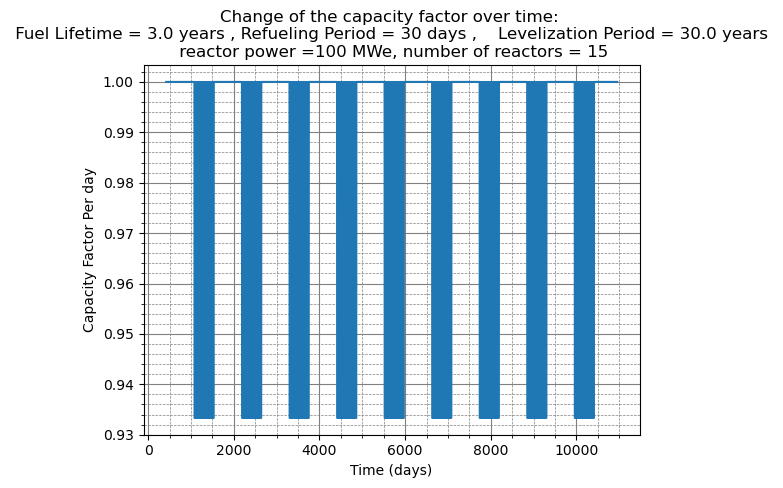

Capacity Factor over the plant lifetime is : 0.9752160288671541


array([  420,   421,   422, ..., 10948, 10949, 10950])

In [45]:
fuel_lifetime = 30 * 12* 3 # days
refueling_period = 30 # days
num_reactors = 15
power1 = 100
levelization_period = 30*365


times_array_excludingRampUp = (capacity_factor(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period, power1*num_reactors ))[0]
capacity_factor_t = (capacity_factor(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period, power1*num_reactors ))[1]
overall_capacity_factor   = (capacity_factor(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period , power1*num_reactors ))[2]


plt.plot(times_array_excludingRampUp, capacity_factor_t )

plt.xlabel('Time (days)')
plt.ylabel('Capacity Factor Per day')
plt.title(f"Change of the capacity factor over time: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days ,\
    Levelization Period = {np.round(levelization_period/365, 1)} years \n reactor power ={ power1} MWe, number of reactors = {num_reactors}")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.show()


print(f"Capacity Factor over the plant lifetime is : {overall_capacity_factor }")
times_array_excludingRampUp

In [11]:
# number of reactors to achieve the target demand 
refueling_period = 30 # days
levelization_period = 30*365

fuel_lifetime = 2*12*30


demand_0 = 1000 # MWe
power_list = [1000, 500, 300] #, 100, 50, 10, 5, 1]
capacity_factor_criteria_list = [0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]
num_reactors_save_tot = []
for power in power_list :
    num_reactors_save = []
    num_reactors_current = 0 # initialization
    for capacity_factor_criteria in capacity_factor_criteria_list :
    
        num_reactors_0 =  max( int( np.ceil( demand_0 /power)), num_reactors_current)
        for  num_reactors in np.linspace( num_reactors_0 , 2*num_reactors_0, 1+num_reactors_0):
            
                
            times_array_excludingRampUp = (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
            # capacity_factor_min =        min ((capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
            overall_capacity_factor   =   (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[2]
            print( power, num_reactors, capacity_factor_criteria, overall_capacity_factor  )
            if  overall_capacity_factor>=  capacity_factor_criteria:
                num_reactors_save.append(num_reactors)
                num_reactors_current = int(num_reactors)
                
                break
    
            
    num_reactors_save_tot.append(num_reactors_save)        

1000 1.0 0.9 0.9629257602045476
1000 1.0 0.92 0.9629257602045476
1000 1.0 0.94 0.9629257602045476
1000 1.0 0.96 0.9629257602045476
1000 1.0 0.98 0.9629257602045476
1000 2.0 0.98 1.9256478344473948
1000 2.0 0.99 1.9256478344473948
1000 2.0 0.999 1.9256478344473948
1000 2.0 0.9999 1.9256478344473948
1000 2.0 0.99999 1.9256478344473948
1000 2.0 1 1.9256478344473948
500 2.0 0.9 0.9628239172236974
500 2.0 0.92 0.9628239172236974
500 2.0 0.94 0.9628239172236974
500 2.0 0.96 0.9628239172236974
500 2.0 0.98 0.9628239172236974
500 3.0 0.98 1.4440822697640254
500 3.0 0.99 1.4440822697640254
500 3.0 0.999 1.4440822697640254
500 3.0 0.9999 1.4440822697640254
500 3.0 0.99999 1.4440822697640254
500 3.0 1 1.4440822697640254
300 4.0 0.9 1.1551422520946506
300 4.0 0.92 1.1551422520946506
300 4.0 0.94 1.1551422520946506
300 4.0 0.96 1.1551422520946506
300 4.0 0.98 1.1551422520946506
300 4.0 0.99 1.1551422520946506
300 4.0 0.999 1.1551422520946506
300 4.0 0.9999 1.1551422520946506
300 4.0 0.99999 1.15514

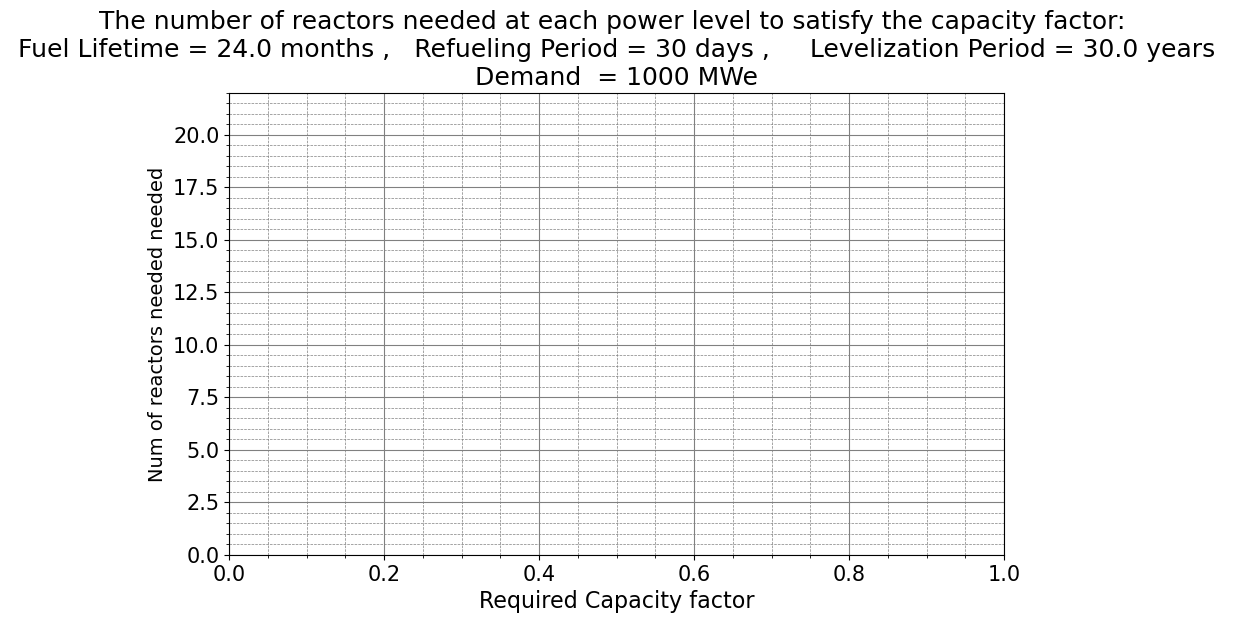

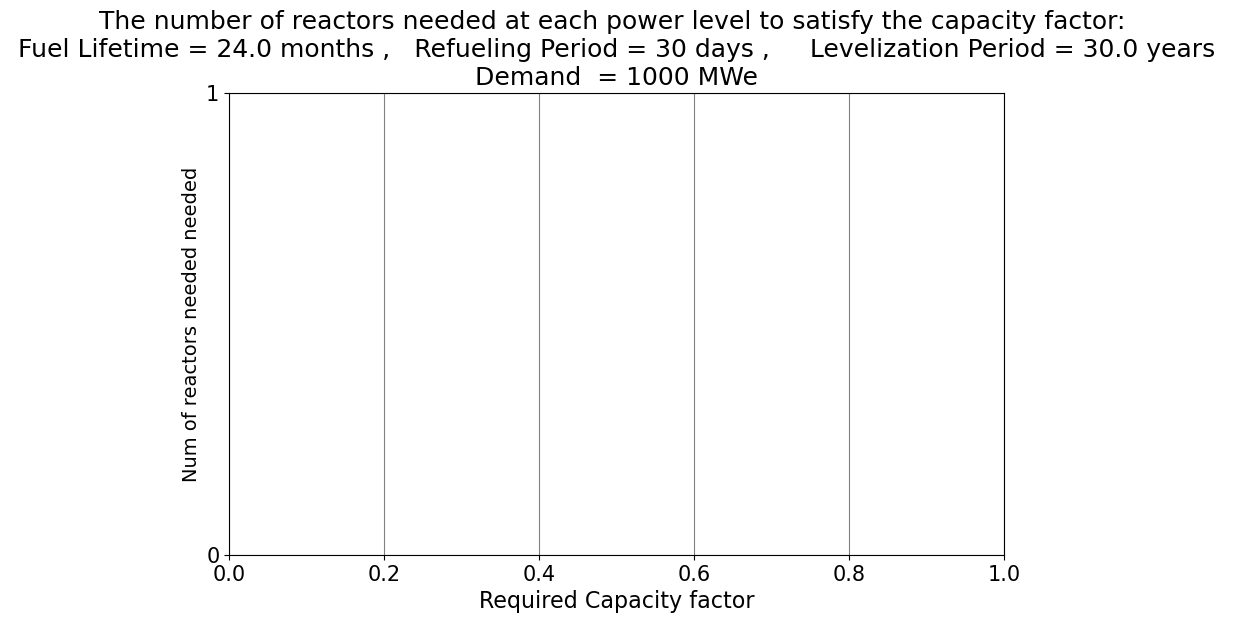

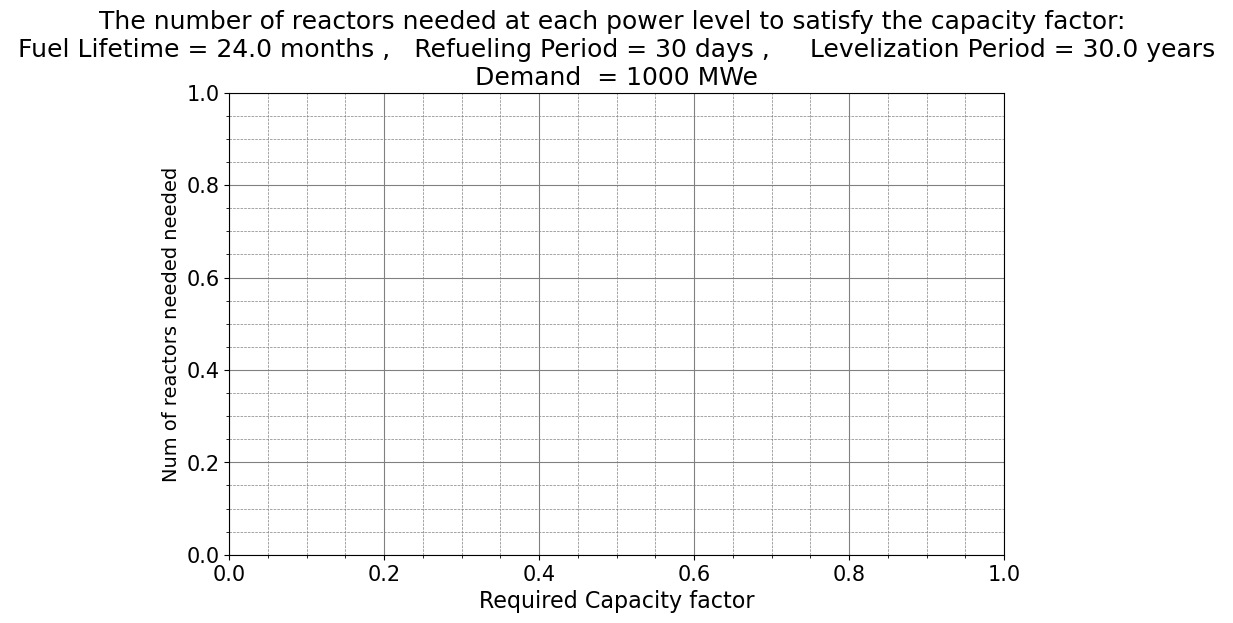

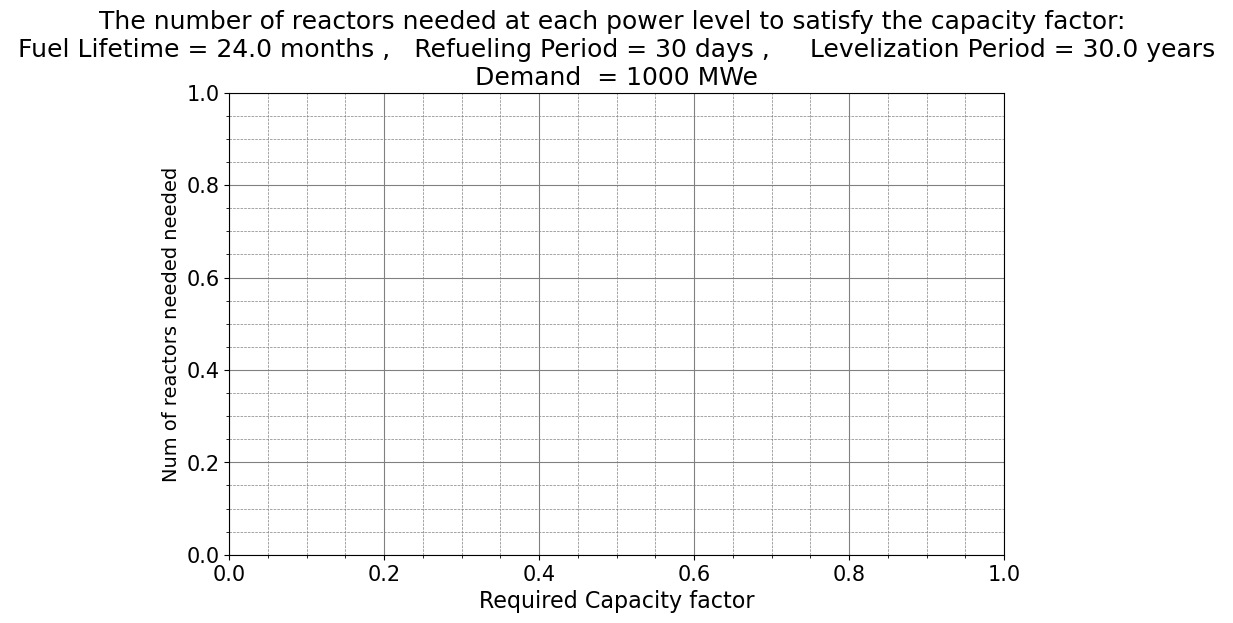

In [12]:
fig = plt.figure(figsize=(10, 6))



for i in range(len(num_reactors_save_tot) - 3):
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.ylim(0, 22)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()




fig = plt.figure(figsize=(10, 6))


for i in range(5, len(num_reactors_save_tot) -2):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'b',label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# plt.ylim(0, 12)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))


plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
# plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()

fig = plt.figure(figsize=(10, 6))
for i in range(6, len(num_reactors_save_tot) -1):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'y',label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()





fig = plt.figure(figsize=(10, 6))
for i in range(7, len(num_reactors_save_tot) ):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'k',label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()



plt.show()

# Minimum Capacity Factor

In [14]:
# number of reactors to achieve the target demand 
refueling_period = 30 # days
levelization_period = 30*365

fuel_lifetime = 2*12*30


demand_0 = 1000 # MWe
power_list = [1000, 500 , 300 ] # 100, 50, 10, 5, 1
min_capacity_factor_criteria_list = [0.9, 0.92  , 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]

n_reactors_save_tot = []
for power in power_list :
    n_reactors_save = []
    n_reactors_current = 0 # initialization
    for min_capacity_factor_criteria in min_capacity_factor_criteria_list :
    
        n_reactors_0 =  max( int( np.ceil( demand_0 /power)), n_reactors_current)
        for  num_reactors in np.linspace( n_reactors_0 , 2*n_reactors_0, 1+n_reactors_0):
            
                
            times_array_excludingRampUp = (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
            capacity_factor_min =        min ((capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
            print( power, num_reactors, min_capacity_factor_criteria, capacity_factor_min  )
            if  capacity_factor_min >=  min_capacity_factor_criteria:
                n_reactors_save.append(num_reactors)
                n_reactors_current = int(num_reactors)
                
                break
    
            
    n_reactors_save_tot.append(n_reactors_save) 

1000 1.0 0.9 0.0
1000 2.0 0.9 1.0
1000 2.0 0.92 1.0
1000 2.0 0.94 1.0
1000 2.0 0.96 1.0
1000 2.0 0.98 1.0
1000 2.0 0.99 1.0
1000 2.0 0.999 1.0
1000 2.0 0.9999 1.0
1000 2.0 0.99999 1.0
1000 2.0 1 1.0
500 2.0 0.9 0.5
500 3.0 0.9 1.0
500 3.0 0.92 1.0
500 3.0 0.94 1.0
500 3.0 0.96 1.0
500 3.0 0.98 1.0
500 3.0 0.99 1.0
500 3.0 0.999 1.0
500 3.0 0.9999 1.0
500 3.0 0.99999 1.0
500 3.0 1 1.0
300 4.0 0.9 0.9
300 4.0 0.92 0.9
300 5.0 0.92 1.2
300 5.0 0.94 1.2
300 5.0 0.96 1.2
300 5.0 0.98 1.2
300 5.0 0.99 1.2
300 5.0 0.999 1.2
300 5.0 0.9999 1.2
300 5.0 0.99999 1.2
300 5.0 1 1.2


In [15]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange']

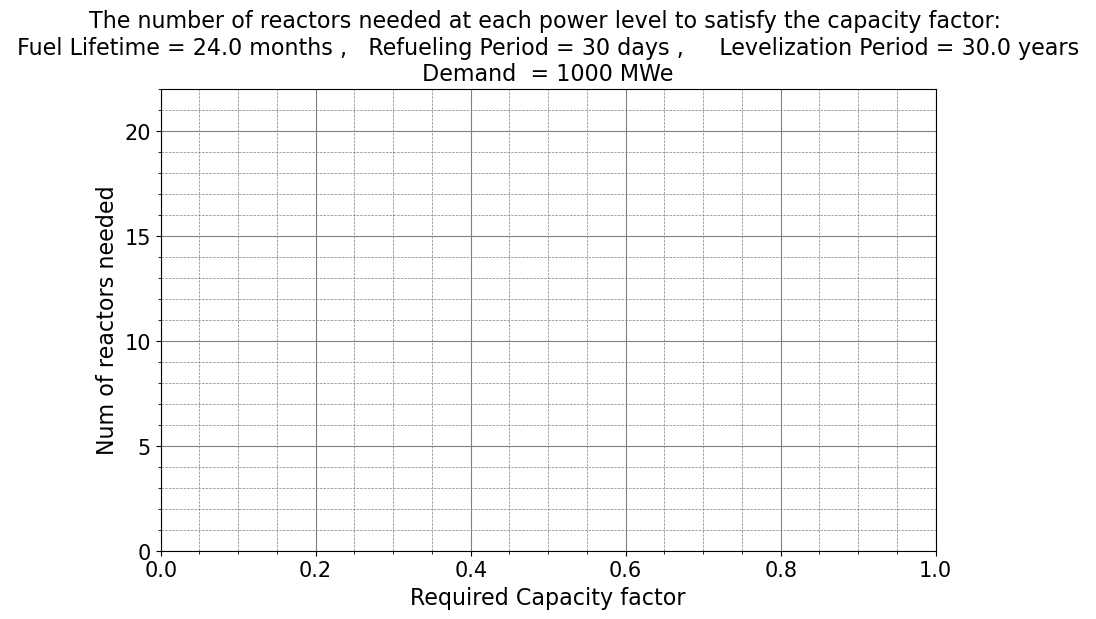

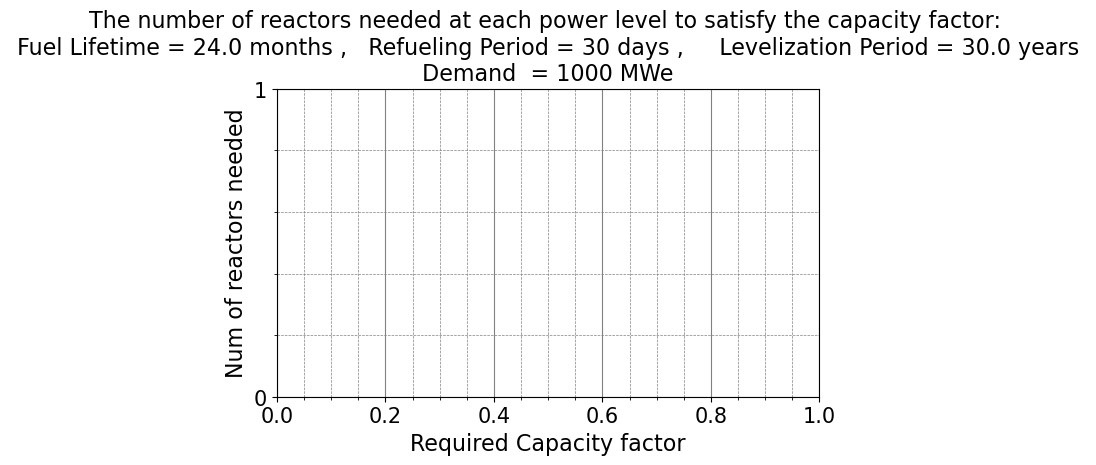

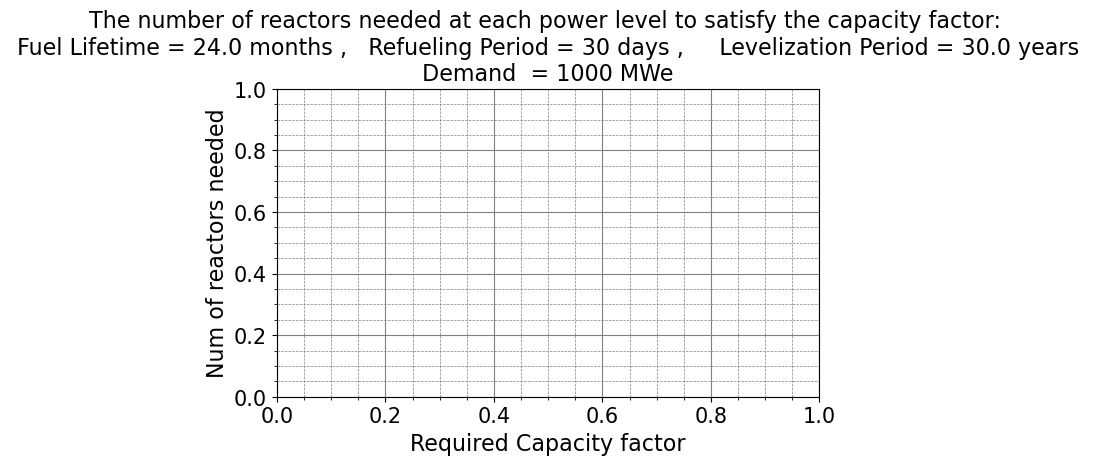

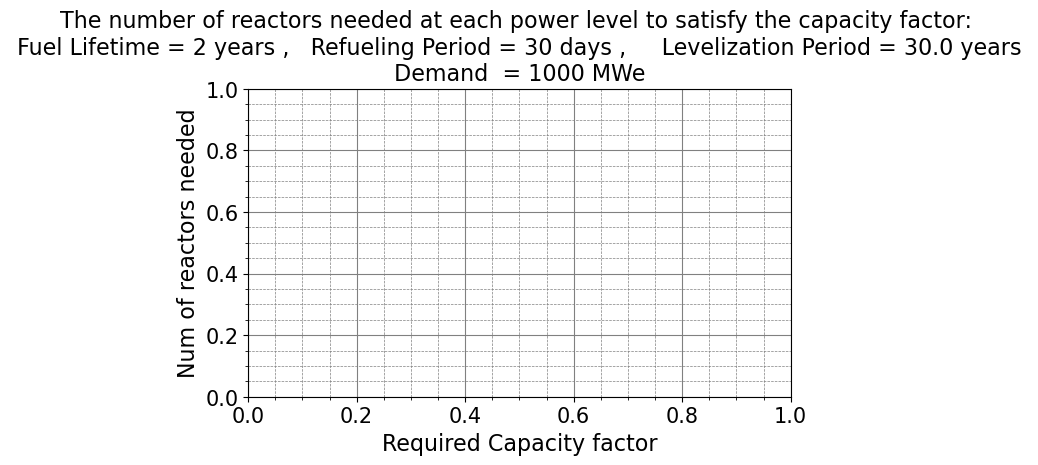

In [16]:
fig = plt.figure(figsize=(10, 6))



for i in range(len(num_reactors_save_tot) - 3):
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = colors[i] ,alpha=0.5, label =f'Power = {power_list[i]} MWe, Avg Capacity Factor')
    plt.plot(min_capacity_factor_criteria_list, n_reactors_save_tot[i],linestyle = 'dashed', color = colors[i],label =f'Power = {power_list[i]} MWe, Daily Capacity Factor')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=16 )

plt.ylim(0, 22)

# plt.xscale('log')
plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed',  fontsize=16)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15) 
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))
plt.savefig(f'num_reactors_to_satisfy_reliability1.png', bbox_inches='tight')

plt.show()




fig = plt.figure(figsize=(7, 4))


for i in range(5, len(num_reactors_save_tot) -2):
    
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = colors[i],label =f'Power = {power_list[i]} MWe,  Avg Capacity Factor')
    plt.plot(min_capacity_factor_criteria_list, n_reactors_save_tot[i],linestyle = 'dashed', color = colors[i],label =f'Power = {power_list[i]} MWe, Daily Capacity Factor')

    plt.legend(loc='upper left')

# plt.ylim(0, 12)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed',  fontsize=16)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))


plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.savefig(f'num_reactors_to_satisfy_reliability2.png', bbox_inches='tight')

plt.show()

fig = plt.figure(figsize=(7, 4))
for i in range(6, len(num_reactors_save_tot) -1):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = colors[i],label =f'Power = {power_list[i]} MWe,  Avg Capacity Factor')
    plt.plot(min_capacity_factor_criteria_list, n_reactors_save_tot[i],linestyle = 'dashed', color = colors[i],label =f'Power = {power_list[i]} MWe, Daily Capacity Factor')

    plt.legend( loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed',  fontsize=16)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.savefig(f'num_reactors_to_satisfy_reliability3.png', bbox_inches='tight')

plt.show()





fig = plt.figure(figsize=(7, 4))
for i in range(7, len(num_reactors_save_tot) ):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = colors[i],label =f'Power = {power_list[i]} MWe,  Avg Capacity Factor')
    plt.plot(min_capacity_factor_criteria_list, n_reactors_save_tot[i],linestyle = 'dashed', color = colors[i],label =f'Power = {power_list[i]} MWe, Daily Capacity Factor')
    plt.legend(loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed',  fontsize=16)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {int(np.round(fuel_lifetime/30/12, 1))} years ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.savefig(f'num_reactors_to_satisfy_reliability4.png', bbox_inches='tight')

plt.show()



In [ ]:

# fuel_lifetime_0 = 2*12*30 # days
# refueling_period_0 = 30 # days
# levelization_period_0 = 30*365 # days
# demand_0 = 3000

# overall_capacity_factor_criteria = 0.99
# min_capacity_factor_criteria = 0.9

# # ref large reactor
# ref_large_reactor_cost_per_kw = 1 # the cost here does not matter because we calculate ratios
# large_reactor_ref_power = 1000 # This is the average power in the GAIN metanalaysis report (and i rouneded it)
# LR_Large = 0.061 # from PWR (76% cost ratio for the 20th reactor) ... 8% in the GAIN report

# # small reactor

# lr_small_min = 0
# lr_small_max = 0.2
# lr_small_interval = 0.01

# num_LR_small = 1+abs(int(np.ceil( (lr_small_min - lr_small_max)/ lr_small_interval) ) ) 

# min_cost_small = cost_large 
# max_cost_small = 50*cost_large 
# cost_interval_small = 20 # 50 dollars
# num_cost_small = int(np.ceil(1 + abs(max_cost_small  - min_cost_small )/ cost_interval_small  ) )


# # #Step1 : calculate cost of the large ractor
# num_reactors_needed_large = num_reactors_needed_for_capacity_factor(overall_capacity_factor_criteria, min_capacity_factor_criteria, fuel_lifetime_0, refueling_period_0, power_large, levelization_period_0, demand_0)

# final_cost_large = calculate_final_cost_due_to_learning_rate(cost_large , LR_Large, int(num_reactors_needed_large)  )

# final_cost_per_demand_large = final_cost_large * (num_reactors_needed_large*power_large/demand_0)

# power_list = [300, 100 ] # ,50 ,20, 10, 5, 1

# # # Step2: calculate cost of small reactor that matches the large reactor
# lr_small_save_tot = []
# tipping_cost_save_tot = []
# for power_small in power_list:
    
#     num_reactors_needed_small = num_reactors_needed_for_capacity_factor(overall_capacity_factor_criteria, min_capacity_factor_criteria, fuel_lifetime_0, refueling_period_0, power_small, levelization_period_0, demand_0)

#     lr_small_save = []
#     tipping_cost_save = []

#     for lr_small in np.linspace(lr_small_min, lr_small_max , num_LR_small ): 
          
        
#         for cost_small in np.linspace(max_cost_small, min_cost_small, num_cost_small):
        
#             final_cost_small = calculate_final_cost_due_to_learning_rate(cost_small , lr_small, int(num_reactors_needed_small)  )
#             final_cost_per_demand_small = final_cost_small* (num_reactors_needed_small*power_small/demand_0)
#             if final_cost_per_demand_small  <=  final_cost_per_demand_large:
#                 cost_tipping_point = final_cost_per_demand_small
#                 tipping_cost_save.append(cost_small)
#                 lr_small_save.append(lr_small)
#                 print(power_small, "MWe", "LR = ", lr_small)  
#                 break
#     lr_small_save_tot.append(lr_small_save)
#     tipping_cost_save_tot.append( tipping_cost_save)

In [ ]:
# fig = plt.figure(figsize=(16, 10))

# for i in range (len(lr_small_save_tot)):
#     plt.plot(lr_small_save_tot[i], np.array(tipping_cost_save_tot[i])/cost_large ,'-o' , markersize = 10, label =f'Power = {power_list [i]} MWe')
#     plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


# plt.grid(which='major', color='grey', linewidth=0.8)
# plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
# plt.minorticks_on()
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)  

# plt.xlabel('Learning Rate',  fontsize=16 )
# plt.ylabel('Small Reactor to Large Reactor \n FOAK Cost (USD/ MWe) Ratio \n',  fontsize=14)
# plt.xlim(0, 0.2)
# plt.ylim(1, 15)
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.02))

# plt.title(f"Cost Tipping Point: Where the total Cost of an SMR/micro reactor ($/demand in MWe) equals the cost of a large reactor : \n Fuel Lifetime = {np.round(fuel_lifetime_0 /30, 1)} months ,   Refueling Period = {refueling_period_0} days ,\
#      Levelization Period = {np.round(levelization_period_0/365, 1)} years \n Demand  = {demand_0} MWe , Target Capacity Factor (per day) = {min_capacity_factor_criteria} \n"  , fontsize=16)
# plt.show()

# cost tipping points

In [ ]:
fig = plt.figure(figsize=(12, 8))

lr_interval = 0.01
demand = 6000
ref_large_reactor_cost_per_kw = 1 # the cost here does not matter because we calculate ratios
min_cost_small = ref_large_reactor_cost_per_kw
max_cost_small = 18 *min_cost_small 
num_cost = 600

fuel_lifetime_large = 2*12*30 # days (2 years for the reference large reactor)
fuel_lifetime_SMR = 3*12*30 # days (3 years for SMR)
fuel_lifetime_micro = 4*12*30 # days 
# These are the learning rates for the small reactors
# For the learning rate, Using the GAIN meta study
# https://inldigitallibrary.inl.gov/sites/sti/sti/Sort_107010.pdf
large_lr_avg = 0.08 # AVG L 8% Learning rate
large_lr_std = 0.03 # std = 0.03
large_lr_lo = large_lr_avg - large_lr_std
large_lr_hi = large_lr_avg + large_lr_std


refueling_period_large = 28 # 4 weeks for large reactors
refueling_period_SMR = 21 # 3 weeks
refueling_period_micro = 14 # 2 weeks
levelization_period_0 = 30*365 # days

overall_capacity_factor_criteria = 0.9
min_capacity_factor_criteria     = 0.99

large_reactor_ref_power = 1000 # This is the average power in the GAIN metanalaysis report (and i rouneded it)

lr_min = 0
lr_max = 0.17
pwr_list = [500 ,  300   , 200, 100  ,50, 20,5, 1]

num_LR_small = 1+int(np.ceil( (lr_max - lr_min )/ lr_interval) )

for power in pwr_list:
    print("power (MW) = ", power)
    
    if power <= 500 and power >50:
        fuel_lifetime_small = fuel_lifetime_SMR  # days (3 years for SMR)
        refueling_period_small = refueling_period_SMR # 3 weeks for SMR
        
    elif power<=50:    
        fuel_lifetime_small =fuel_lifetime_micro # days (4 years for microreactors)
        refueling_period_small = refueling_period_micro # 2 weeks for microreactors
    
    lr_small_list = []
    lr_small_list1 = []
    breakeven_points_0_list = []
    breakeven_points_1_list = []
    avg_point_list = []
    
    num_large_reactors = int(np.ceil(num_reactors_needed_for_capacity_factor(overall_capacity_factor_criteria,\
            min_capacity_factor_criteria, fuel_lifetime_large, refueling_period_large, large_reactor_ref_power ,\
                levelization_period_0, demand)))

    num_small_reactors =  int(np.ceil(num_reactors_needed_for_capacity_factor(overall_capacity_factor_criteria,\
            min_capacity_factor_criteria, fuel_lifetime_small, refueling_period_small, power ,\
                levelization_period_0, demand)))
    
    for lr_small in np.linspace(lr_min,lr_max ,num_LR_small) :
        if power <=5:
            print( 'LR = ', lr_small)
        
        try:
            breakeven_points = calculate_break_even_cost_for_lr_per_demand(lr_small, large_lr_lo, large_lr_hi,\
    ref_large_reactor_cost_per_kw, num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small,\
        num_cost, demand, large_reactor_ref_power, power)
            
            
            lr_small_list.append(lr_small)
            breakeven_points_0_list.append(breakeven_points[0])
            breakeven_points_1_list.append(breakeven_points[1])
            
        except:
            ...

        try:
            # For the 8% avg LR for the large reactor
            avg_point = calculate_break_even_cost_for_lr_per_demand(lr_small, large_lr_avg, large_lr_avg,\
    ref_large_reactor_cost_per_kw, num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small,\
        num_cost, demand, large_reactor_ref_power, power)
            
            avg_point_list.append(avg_point[0])
            lr_small_list1.append(lr_small)
        except:
            ...
            
    plt.fill_between(lr_small_list, breakeven_points_0_list , breakeven_points_1_list, alpha=0.25)  
    plt.plot(lr_small_list1, avg_point_list,  '-o' , markersize = 8,label = f"Power = {int(power)} MWe")     

plt.legend( loc='upper left', fontsize=16, edgecolor='black', fancybox=True)   # bbox_to_anchor=(1.05, 1.0)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.xlabel('Learning Rate', fontsize=16) 
plt.ylabel('Economies of Scale Penalty Crossover Point\n (adjusted for demand)\n', fontsize=16)  

plt.ylim(1, max(breakeven_points_1_list)+0.2 )
plt.xlim(0, lr_max ) 
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.title(f' Demand = {demand } MWe \n Target Capacity Factor (per day) = {min_capacity_factor_criteria}  \n \
    Operational lifetime for large reactors, SMRs, microreactors are {int(fuel_lifetime_large/30)}, {int(fuel_lifetime_SMR/30)}, {int(fuel_lifetime_micro/30)} months respectively \n \
        Refueling Duration for large reactors, SMRs, microreactors are {refueling_period_large}, {refueling_period_SMR}, {refueling_period_micro} respectively \n' , fontsize=16) 
plt.savefig(f'lr_vs_costTipping_adjustedForDemand_{demand}.png', bbox_inches='tight')

plt.show()     